In [1]:
import sys 
#sys.path.append("codes/modules") # add custom Vibe 's modules
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')

import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

sys.path.append('/home/hbkoziel/pyfesom/pyfesom/python-gsw/')
import gsw

No joblib
no cmocean


In [2]:
def Turner_Rsubrho(SA, CT, p):
    SA, CT, p = np.broadcast_arrays(SA, CT, p, subok=True)
    p_mid = 0.5 * (p[0:-1, ...] + p[1:, ...])
    SA_mid = 0.5 * (SA[0:-1, ...] + SA[1:, ...])
    CT_mid = 0.5 * (CT[0:-1, ...] + CT[1:, ...])

    dSA = SA[0:-1, ...] - SA[1:, ...]
    dCT = CT[0:-1, ...] - CT[1:, ...]
    [rho, alpha, beta] = gsw.rho_alpha_beta(SA_mid, CT_mid, p_mid)
    #Tu = np.arctan2((alpha * dCT + beta * dSA), (alpha * dCT - beta * dSA))
    #Tu = Tu * (180 / np.pi)

    Rsubrho = np.zeros_like(dSA) + np.NaN
    Inz = dSA != 0
    Rsubrho[Inz] = (alpha[Inz] * dCT[Inz]) / (beta[Inz] * dSA[Inz])
    return Rsubrho, rho

In [3]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/home/hbkoziel/pyfesom/data/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'SAPE'
first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'

/home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh


In [4]:
pressure = gsw.p_from_z(-mesh.z3, mesh.y3, geo_strf_dyn_height=0)

In [5]:
# ==============================================================================
# Settings for netcdf file

save_netcdf       = True                                            # Saves the interpolated field in netcdf file
delete_old_netcdf = True                                            # If a netcdf file with the same name exists it will be deleted
input_directory  = '/scratch/usr/hbkoziel/'+runid+'/netcdf/'       # Where the netcdf is saved
output_directory  = '/scratch/usr/hbkoziel/'+runid+'/netcdf/'
plot_netcdf       = True                                           # Reads DIN from the created netcdf file, else it plots the interpolated field (should be the same)

In [6]:
ind = 0
netcdf_name       = tracername+'.'+str(years[ind])+'.monthly.nc'
print years[ind]

1985


In [7]:
ncfile1	= input_directory+'temp.'+str(years[ind])+'.monthly.nc'
f1	= Dataset(ncfile1,'r')
t	= f1.variables['temp'][8,:]
f1.close()
    
ncfile2	= input_directory+'salt.'+str(years[ind])+'.monthly.nc'
f2	= Dataset(ncfile2,'r')
s	= f2.variables['salt'][8,:]
f2.close()
    
ncfile3	= input_directory+'mixlay.'+str(years[ind])+'.monthly.nc'
f3	= Dataset(ncfile3,'r')
mld	= f3.variables['mixlay'][8,:]
f3.close()

In [15]:
i = 600000
print mesh.y2[i]
print mesh.topo[i]

83.3177611097944
3400.0


In [17]:
ind_depth = np.array(mesh.n32[i,0:20]) # depth max 580m
ind_depth = np.reshape(ind_depth, ind_depth.size)

z = pressure[ind_depth]
            
tt = t[ind_depth]
tt = np.reshape(tt, tt.size)
ss = s[ind_depth]
ss = np.reshape(ss, ss.size)
[Ro1,ro] = Turner_Rsubrho(ss,tt,z)
hl_ind = (np.abs(0.1-Ro1)).argmin(axis=0)
HLD = mesh.z3[ind_depth[hl_ind]]

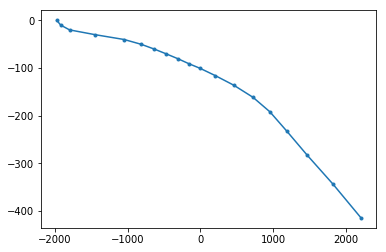

In [31]:
plt.plot((ro-ro[hl_ind])*9.81*100,-z[:-1],'.-')

In [30]:
HLD

100.0

In [83]:
0.5*np.trapz(HLD*9.81*(ro[0:hl_ind+1]-ro[hl_ind]),-mesh.z3[ind_depth[:hl_ind+1]])

47895.23351114257

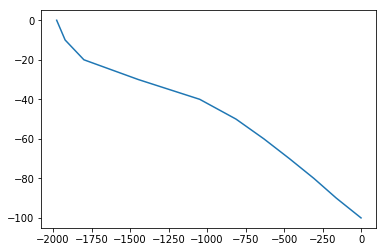

In [33]:
plt.plot(HLD*9.81*(ro[0:hl_ind+1]-ro[hl_ind]),-mesh.z3[ind_depth[:hl_ind+1]])

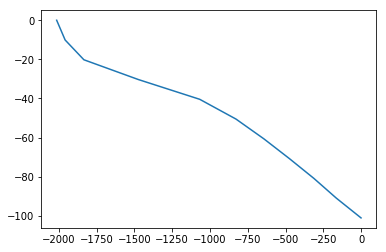

In [38]:
plt.plot(1000*(ro[0:hl_ind+1]-ro[hl_ind]),-z[:hl_ind+1])

In [96]:
z

array([  0.        ,  10.108057  ,  20.21660999,  30.32565889,
        40.43520361,  50.54524407,  60.6557802 ,  70.76681191,
        80.87833912,  90.99036174, 101.1028797 , 116.27258522,
       136.50059215, 161.78838495, 192.13781799, 232.61065161,
       283.21281234, 343.95169917, 414.83617737, 495.87657109])

In [97]:
z[:]**2

array([0.00000000e+00, 1.02172816e+02, 4.08711320e+02, 9.19645587e+02,
       1.63500569e+03, 2.55482170e+03, 3.67912367e+03, 5.00794167e+03,
       6.54130574e+03, 8.27924593e+03, 1.02217923e+04, 1.35193141e+04,
       1.86324117e+04, 2.61754815e+04, 3.69169411e+04, 5.41077152e+04,
       8.02094971e+04, 1.18302771e+05, 1.72089054e+05, 2.45893574e+05])

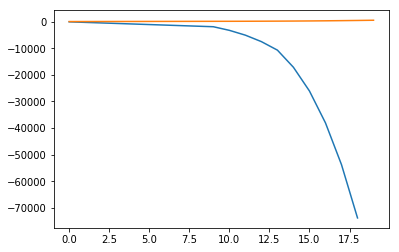

In [94]:
dz2 = z[:-1]**2 - z[1:]**2
plt.plot(dz2)
plt.plot(z)

In [84]:
pe = np.sum(0.5 * 9.81 * (ro[:hl_ind]-ro[hl_ind]) * dz2[:hl_ind])
print np.log10(pe)
print pe

4.545180719914582
35089.786024008055


In [92]:
pe2 = np.trapz(HLD*9.81*(ro[0:hl_ind+1]-ro[hl_ind]),-mesh.z3[ind_depth[:hl_ind+1]])
print np.log10(pe2)
print pe2

4.98132229064826
95790.46702228514


In [93]:
pe3 = np.trapz(HLD*9.81*(ro[0:hl_ind]-ro[1:hl_ind+1]),-mesh.z3[ind_depth[:hl_ind]])
print np.log10(pe3)
print pe3

4.271603053433205
18689.731119623553


In [99]:
HLD

100.0